In [1]:
from portiloop_software.portiloop_python.ANN.data.mass_data import read_sleep_staging_labels, read_spindle_trains_labels
from portiloop_software.portiloop_python.ANN.models.lstm import get_trained_model
import torch

from portiloop_software.portiloop_python.ANN.utils import get_configs

experiment_name = 'test_adapation'
seed = 42
model_path = 'no_att_baseline'
subject_id = '01-02-0019'
train = False

config = get_configs(experiment_name, False, seed)
# config['nb_conv_layers'] = 4
# config['hidden_size'] = 64
# config['nb_rnn_layers'] = 4

# Load the model
net = get_trained_model(config, config['path_models'] / model_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run some testing on subject 1
# Load the data
labels = read_spindle_trains_labels(config['old_dataset'])
ss_labels = read_sleep_staging_labels(config['path_dataset'])
# for index, patient_id in enumerate(ss_labels.keys()):


/project/portiloop-training/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


558


In [2]:
import time

import numpy as np
from portiloop_software.portiloop_python.ANN.adaptation_training import run_adaptation
from portiloop_software.portiloop_python.ANN.data.mass_data import SingleSubjectDataset, SingleSubjectSampler, read_pretraining_dataset
from portiloop_software.portiloop_python.ANN.utils import get_metrics


config['subject_id'] = subject_id

data = read_pretraining_dataset(config['MASS_dir'], patients_to_keep=[subject_id])

assert subject_id in data.keys(), 'Subject not in the dataset'
assert subject_id in labels.keys(), 'Subject not in the dataset'

dataset = SingleSubjectDataset(config['subject_id'], data=data, labels=labels, config=config, ss_labels=ss_labels)  
sampler = SingleSubjectSampler(len(dataset), config['seq_stride'])
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=1, 
    sampler=sampler, 
    num_workers=0)

# Run the adaptation
start = time.time()
# run_adaptation(dataloader, net, device, config)
output_total, window_labels_total, loss, net_copy = run_adaptation(dataloader, net, device, config, train)
end = time.time()
print('Time: ', end - start)

print("Distribution of the predictions:")
print(np.unique(output_total.cpu().numpy(), return_counts=True))
print("Distribution of the labels:")
print(np.unique(window_labels_total.cpu().numpy(), return_counts=True))

# Get the metrics
acc, f1, precision, recall = get_metrics(output_total, window_labels_total)

Number of spindles: 73
Number of spindle labels: 12410
len of full signal: 6598000
Length of sampler: 157094
Doing index: 0/157094
Doing index: 10000/157094
Doing index: 20000/157094
Doing index: 30000/157094
Doing index: 40000/157094
Doing index: 50000/157094
Doing index: 60000/157094
Doing index: 70000/157094
Doing index: 80000/157094
Doing index: 90000/157094
Doing index: 100000/157094
Doing index: 110000/157094
Doing index: 120000/157094
Doing index: 130000/157094
Doing index: 140000/157094
Doing index: 150000/157094
Time:  263.06500244140625
Distribution of the predictions:
(array([0., 1.], dtype=float32), array([152600,   4494]))
Distribution of the labels:
(array([0., 1.], dtype=float32), array([156799,    295]))


In [3]:
from scipy.signal import firwin, remez, kaiser_atten, kaiser_beta, kaiserord , filtfilt
import numpy as np

class RMSScorer:
    def __init__(self, fs=250, lowcut=11, highcut=16):
        self.fs = fs
        self.lowcut = lowcut
        self.highcut = highcut
        self.stopband_att = 60
        self.width = 0.5
        self.ntaps, _ = kaiserord(self.stopband_att, self.width / (0.5 * self.fs))
        self.atten = kaiser_atten(self.ntaps, self.width / (0.5 * self.fs))
        self.beta = kaiser_beta(self.atten)
        self.a = 1.0
        self.taps = firwin(self.ntaps, [self.lowcut, self.highcut], fs=fs,
                           pass_zero=False, window=('kaiser', self.beta), scale=False)
        self.padlen = 1250
        self.size_window = int(0.5 * self.fs)
        self.baseline_idx = int(-2 * self.fs) # Index compared to the detection window

    def get_score(self, candidate):
        # Filter the signal
        filtered_signal = filtfilt(self.taps, self.a, candidate, padlen=self.padlen)

        # Get the baseline and the detection window for the RMS
        detect_index = len(candidate) // 2
        baseline = filtered_signal[detect_index + self.baseline_idx:detect_index + self.baseline_idx + self.size_window]
        detection = filtered_signal[detect_index:detect_index + self.size_window]

        # Calculate the RMS
        baseline_rms = np.sqrt(np.mean(np.square(baseline)))
        detection_rms = np.sqrt(np.mean(np.square(detection)))

        score = detection_rms / baseline_rms
        return score

In [4]:
import matplotlib.pyplot as plt

from portiloop_software.portiloop_python.ANN.data.mass_data import SleepStageDataset

class SpindlePlotter:
    def __init__(self, signal, spindle_labels, sleep_stage_labels=None, model_spindle_labels=None, min_label_time=0.4, freq=250):
        self.signal = signal
        self.spindle_labels = spindle_labels
        self.sleep_stage_labels = sleep_stage_labels
        self.interval = int(min_label_time * freq)        
        self.freq = freq
        self.scorer = RMSScorer()
        self.spindle_indexes, self.rms_scores = self.find_spindle_indexes()
        if model_spindle_labels is not None:
            self.model_spindle_labels = model_spindle_labels
            self.model_spindle_indexes, self.model_rms_scores = self.find_spindle_indexes(model=True)
        else:
            self.model_spindle_indexes = None

    def find_spindle_indexes(self, model=False):
        if model:
            spindle_labels = self.model_spindle_labels
        else:
            spindle_labels = self.spindle_labels

        # Find the indexes where we have a 1 followed by a zero
        indexes = np.where((spindle_labels == 1) & (np.roll(spindle_labels, 1) == 0))[0]
        indexes = indexes[np.insert(np.diff(indexes) >= self.interval, 0, True)]

        rms_scores = [self.scorer.get_score(self.signal[index - 1250:index + 1250]) for index in indexes if index - 1250 >= 0 and index + 1250 < len(self.signal)]

        return indexes, rms_scores

    def plot(self, index, model=False, time_before=10, time_after=5):
        """
        Plot the signal around the spindle at given index
        """

        if model:
            main_indexes = self.model_spindle_indexes
            secondary_indexes = self.spindle_indexes
            rms_scores = self.model_rms_scores
        else:
            main_indexes = self.spindle_indexes
            secondary_indexes = self.model_spindle_indexes
            rms_scores = self.rms_scores

        print(f"RMS score: {rms_scores[index]}")

        spindle_start = main_indexes[index]
        plot_start = spindle_start - time_before * self.freq
        plot_end = spindle_start + time_after * self.freq + 1 * self.freq # + 1 second to make sure to have the spindle and time after

        eeg_signal = self.signal[plot_start:plot_end]
        plt.plot(eeg_signal)

        # Check if there are other spindles in the window
        for i, spindle_index in enumerate(main_indexes):
            if spindle_index > plot_start and spindle_index < plot_end and i != index:
                plt.axvline(x=spindle_index - plot_start, color='orange', label="Other primary spindles")

        # Check if there are spindles from our model in the window
        if self.model_spindle_indexes is not None:
            for i, spindle_index in enumerate(secondary_indexes):
                if spindle_index > plot_start and spindle_index < plot_end:
                    plt.axvline(x=spindle_index - plot_start, color='blue', label="Secondary spindles")
                
        plt.axvline(x=time_before * self.freq, color='r', label="Spindle Start")
        plt.xlabel("Index")
        plt.ylabel("Signal")

        # Add a legend
        plt.legend()

        plt.show()

        sleep_stages = np.unique(self.sleep_stage_labels[spindle_start])
        if len(sleep_stages) == 1:
            print("Sleep stage: ", SleepStageDataset.get_labels()[sleep_stages[0]])
        else:
            print("Sleep stages: ", [SleepStageDataset.get_labels()[sleep_stage] for sleep_stage in sleep_stages])


    def num_spindles_labels(self):
        return len(self.spindle_indexes)
    
    def num_spindles_model(self):
        if self.model_spindle_indexes is not None:
            return len(self.model_spindle_indexes)
        else:
            return 0

In [5]:
scorer = RMSScorer()
scorer.taps

array([5.41430001e-06, 3.93877677e-06, 2.28498620e-06, ...,
       2.28498620e-06, 3.93877677e-06, 5.41430001e-06])

In [6]:
import tqdm

In [7]:
RMS = []
for index, label in tqdm.tqdm(enumerate(dataset.full_labels)):
    if label == 1 and dataset.full_labels[index - 1] == 0:
        score = scorer.get_score((dataset.full_signal[index-1250:index+1250]))
        RMS.append(score)
RMS = torch.tensor(RMS)

6598000it [00:56, 116417.09it/s]


In [8]:
RMS.mean(), RMS.std()

(tensor(5.5865, dtype=torch.float64), tensor(4.0960, dtype=torch.float64))

In [12]:
# model_output = output_total.cpu().numpy()
plotter = SpindlePlotter(dataset.full_signal, dataset.full_labels, dataset.full_ss_labels)

In [ ]:
for index, i in enumerate(RMS):
    if i < 3:
        print(f"RMS: {i}")
        plotter.plot(index, time_before=2, time_after=1)

# Find maximum index of RMS
# RMS.argmax()

In [10]:
# Sample 72 random indexes in dataset.signal
RMS_fake = []
for i in range(100):
    index = np.random.randint(0, len(dataset.full_signal))
    RMS_fake.append(scorer.get_score(dataset.full_signal[index-1250:index+1250]))
RMS_fake = torch.tensor(RMS_fake)

In [61]:
RMS_fake.mean(),    RMS_fake.std()

(tensor(1.2410, dtype=torch.float64), tensor(1.0236, dtype=torch.float64))

RMS: 20.270483483406892


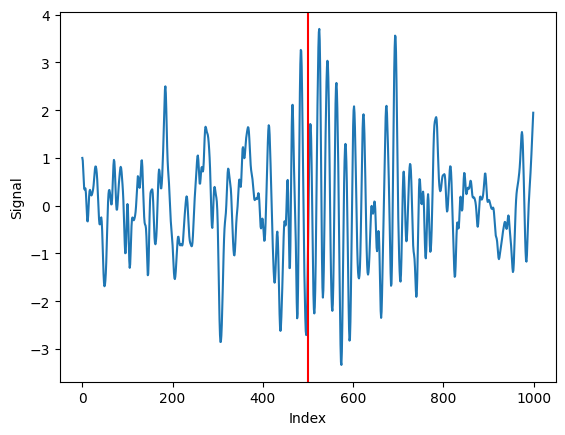

Sleep stage:  2


In [52]:
print(f"RMS: {RMS.max()}")
plotter.plot(17, time_before=2, time_after=1)

In [43]:
RMS.mean(), RMS.std()

(tensor(5.5865, dtype=torch.float64), tensor(4.0960, dtype=torch.float64))

In [12]:
labels_model = np.repeat(output_total.cpu().numpy(), 42)
labels_model = np.append(labels_model, np.zeros(52))

In [13]:
# Keep only the first 1 in each spindle
labels_model = np.diff(labels_model)
labels_model[labels_model == -1] = 0

In [14]:
print(np.unique(labels_model, return_counts=True))

(array([0., 1.]), array([6596139,    1860]))


In [15]:
RMS_model = []
last_index = 0
# labels_model = torch.from_numpy(labels_model)
for index, label in tqdm.tqdm(enumerate(labels_model)):
    if label == 1 and index - last_index > 100 and index > 1250:
        score = scorer.get_score(dataset.full_signal[index-1250:index+1250])
        RMS_model.append(score)
RMS_model = torch.tensor(RMS_model)

6597999it [02:52, 38170.98it/s] 


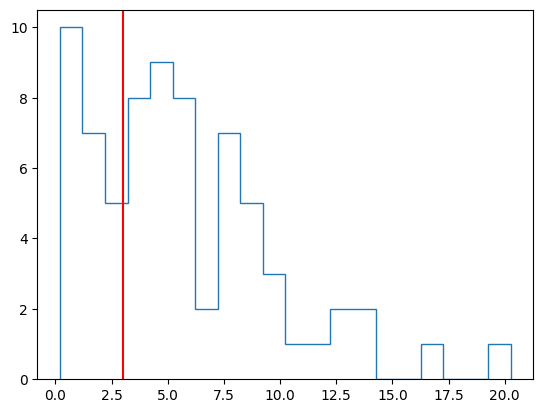

In [20]:
counts, bins = np.histogram(RMS, bins=20)
plt.stairs(counts, bins)
plt.axvline(x=3, color='r', label="Spindle Start")


In [30]:
RMS_model.shape

torch.Size([1861])

In [32]:
RMS.mean(), RMS.std()

(tensor(5.5865, dtype=torch.float64), tensor(4.0960, dtype=torch.float64))

In [31]:
RMS_model.mean(), RMS_model.std()

(tensor(4.1308, dtype=torch.float64), tensor(2.6484, dtype=torch.float64))

In [40]:
# Get the number of values in the RMS_model that are above 3
(RMS_model > 2).sum() / len(RMS_model)

tensor(0.7974)

In [ ]:
# plot the values of RMS_model

In [3]:
data = read_pretraining_dataset(config['MASS_dir'], patients_to_keep=[subject_id])
signal = data[subject_id]['signal']

In [16]:
np.unique(dataset.full_ss_labels, return_counts=True)[1][1:3] / (250 * 60)

array([258.95      ,   5.16666667])

In [48]:
# model_output = output_total.cpu().numpy()
plotter = SpindlePlotter(dataset.full_signal, dataset.full_labels, dataset.full_ss_labels, model_spindle_labels=labels_model)

In [110]:
stage_of_detection = np.unique(np.array([SleepStageDataset.get_labels()[plotter.sleep_stage_labels[index]] for index in plotter.model_spindle_indexes]), return_counts=True)

In [1]:
len(dataset.full_ss_labels)

NameError: name 'dataset' is not defined

In [111]:
stage_of_detection

(array(['1', '2', '3', '?', 'R', 'W'], dtype='<U1'),
 array([  86, 1323,   11,  118,  180,   78]))

In [95]:
plotter.num_spindles_model()

1796

RMS score: 1.883096437190181


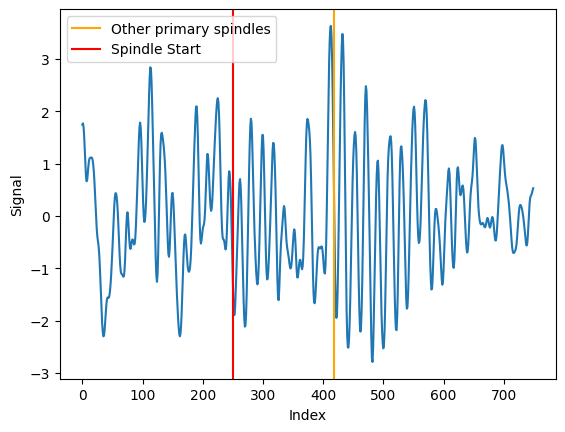

Sleep stage:  2


In [50]:
plotter.plot(900, model=True, time_before=1, time_after=1)

In [77]:
# Average all the f1 scores
print('Subject ', '01-02-0019')
print('Loss: ', loss)
print('Accuracy: ', acc)
print('F1: ', f1)
print('Precision: ', precision)
print('Recall: ', recall)

Subject  01-02-0019
Loss:  0.0
Accuracy:  tensor(0.9721, device='cuda:0')
F1:  0.08371702482754328
Precision:  0.0446129823768768
Recall:  0.6779661014650962
